In [ ]:
 !pip install segmentation_models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import glob 
from PIL import Image
import segmentation_models as sm
import random
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout,BatchNormalization, Lambda
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import backend as K

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Images come in many sizes: 797x644, 509x544, 682x658, 1099x846, 1126x1058, 859x838, 1817x2061,  2149x1479​
#72 images grouped into 6 larger tiles
root_directory = '/content/gdrive/MyDrive/PIBIC/aerial_dubai_semantic_segmentation_dataset/'

In [ ]:
images_dataset = []
masks_dataset = []

for path, subdirs, files in os.walk(root_directory):
  dirname = path.split(os.path.sep)[-1]
  
  if dirname == 'images':
    images = os.listdir(path)
    images.sort()
    for count,image_name in enumerate(images):
        if image_name.endswith(".jpg"):
            subdir_image_path = os.path.join(path,image_name)
            image  = cv2.imread(subdir_image_path,1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#IMREAD_COLOR = 1)
            image = cv2.resize(image,(512,512))
            images_dataset.append(image)
           
for path, subdirs, files in os.walk(root_directory):
  dirname = path.split(os.path.sep)[-1]
  
  if dirname == 'masks':
    masks = os.listdir(path)
    masks.sort()
    for count,mask_name in enumerate(masks):
        if mask_name.endswith(".png"):
            subdir_mask_path = os.path.join(path,mask_name)
            mask = cv2.imread(subdir_mask_path,1) #IMREAD_COLOR = 1)
            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask,(512,512))
            masks_dataset.append(mask)
            
images_dataset = np.array(images_dataset) 
masks_dataset = np.array(masks_dataset)

In [ ]:
print(images_dataset.shape)

(72, 512, 512, 3)


## visualização 

---



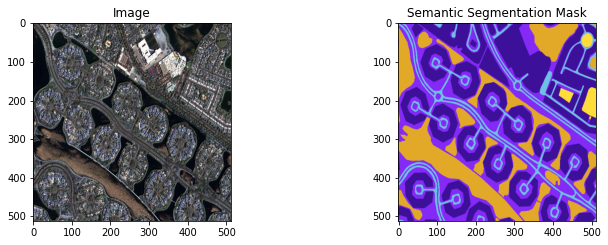

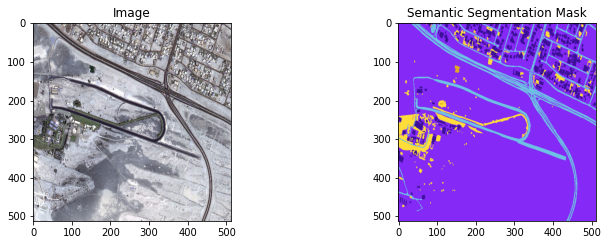

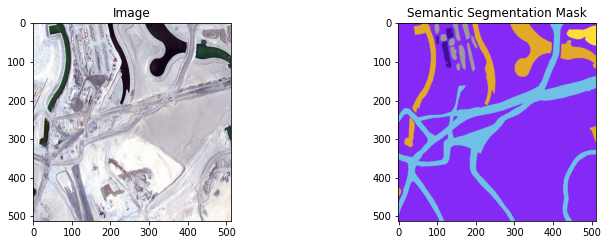

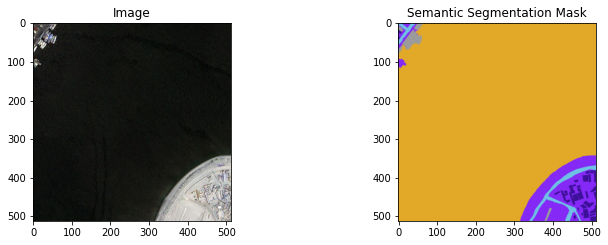

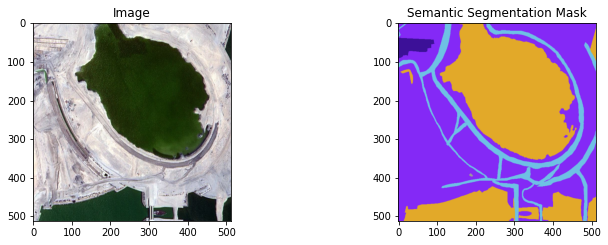

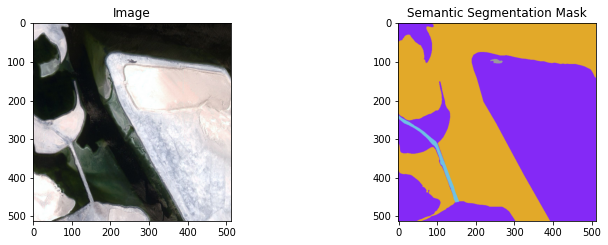

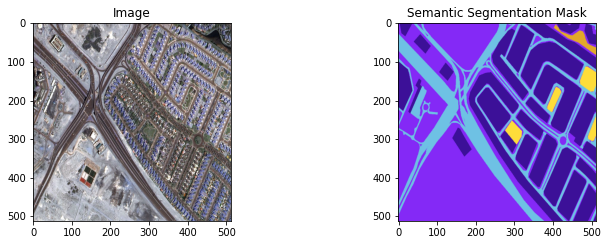

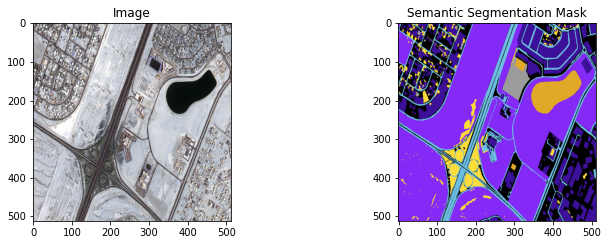

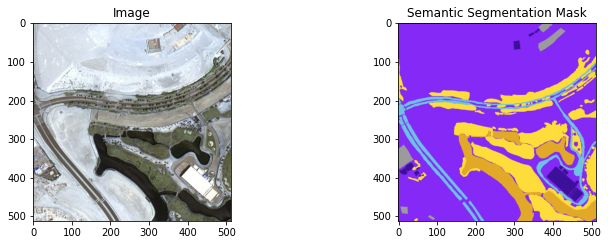

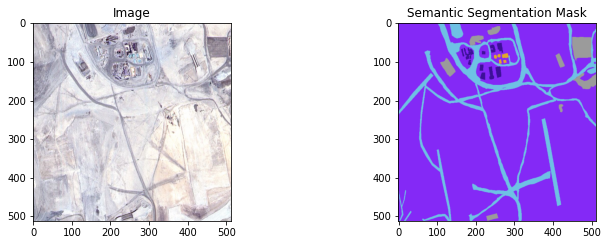

In [ ]:
def visualize(images,masks):
    i = 0
    for i in range(0,10):
        img_number = random.randint(0,len(images)-1)
        img = images[img_number]
        mask = masks[img_number]
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.title('Image')
        plt.imshow(img)
        plt.subplot(222)
        plt.title('Semantic Segmentation Mask')
        plt.imshow(mask)
        plt.show()
        i+=1     

visualize(images_dataset,masks_dataset)

# onehot coding

---



 Now replace RGB to integer values to be used as labels.
Find pixels with combination of RGB for the above defined arrays...
if matches then replace all values in that pixel with a specific integer

In [ ]:
color_dict = {0: (60, 16, 152),
1: (132, 41, 246),
 2: (110, 193, 228),
 3: (254, 221, 58),
 4: (226, 169, 41),
 5: (155, 155, 155)}

label_dict = {0: 'building',
 1: 'land',
 2: 'road',
 3: 'vegetation',
 4: 'water',
 5: 'unlabeled'}


def rgb_to_onehot(rgb_image,colormap = color_dict): 
  num_classes = len(colormap)
  #print(num_classes)
  shape = rgb_image.shape[:2]+(num_classes,) #544,509,6
  encoded_image = np.zeros(shape, dtype=np.int8 ) #Return a new array of given shape and type
  for i, cls in enumerate(colormap):
    encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
  return encoded_image

def onehot_to_rgb(onehot_image, colormap = color_dict):

    single_layer = np.argmax(onehot_image, axis=-1)
    output = np.zeros( onehot_image.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [ ]:
masks_encoded = []
for count,mask in enumerate(masks_dataset):
  mask = rgb_to_onehot(mask,color_dict)
  masks_encoded.append(mask)

masks_encoded = np.array(masks_encoded)
print(masks_encoded.shape)
#onehot_masks = np.expand_dims(onehot_masks, axis=3)


(72, 512, 512, 6)


# label coding 

---




In [ ]:
building = np.array([60,16,152])
land = np.array([132,41,246])
road = np.array([110,193,228])
vegetation = np.array([254,221,58])
water = np.array([226,169,41])
unlabeled = np.array([155,155,155])


def rgb_to_2dlabel(image):
    image_seg = np.zeros(image.shape,dtype=np.uint8)
    image_seg [np.all(image == building,axis=-1)] = 0
    image_seg [np.all(image == land,axis=-1)] = 1
    image_seg [np.all(image == road,axis=-1)] = 2
    image_seg [np.all(image == vegetation,axis=-1)] = 3
    image_seg [np.all(image == water,axis=-1)] = 4
    image_seg [np.all(image == unlabeled,axis=-1)] = 5
    
    image_seg = image_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return image_seg

In [ ]:
masks = []

for count, mask in enumerate(masks_dataset):
  mask = rgb_to_2dlabel(mask)
  masks.append(mask)    

masks = np.array(masks)
print(masks.shape)
#masks = np.expand_dims(masks, axis=3)
print("Unique labels in label dataset are: ", np.unique(masks))

(72, 512, 512)
Unique labels in label dataset are:  [0 1 2 3 4 5]


In [ ]:
n_classes = len(np.unique(masks))
labels_cat = tf.keras.utils.to_categorical(masks, num_classes=n_classes)
#labels_cat é igual ao masks_encoded

# Pre-processamento do modelo 

---




In [ ]:
#images_dataset = tf.keras.utils.normalize(images_dataset, axis=1)
X_train, X_test, y_train, y_test = train_test_split(images_dataset,labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

# Model U-net

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Métricas e compilação

In [ ]:
# compara membros de dois sets distintos para ver qual membro compartilha o mesmo conjunto e qual é distinto. SEmelhante ao IOU
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
metrics=['accuracy']#jacard_coef

In [ ]:
n_classes = 6

def get_model():
    return multi_unet_model(n_classes, IMG_HEIGHT = X_train.shape[1], IMG_WIDTH = X_train.shape[2], IMG_CHANNELS = X_train.shape[3])

model = get_model()
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
4/4 [==============================] - 21s 3s/step - loss: 165.2239 - accuracy: 0.1144 - val_loss: 46.2994 - val_accuracy: 0.1214
Epoch 2/100
4/4 [==============================] - 2s 586ms/step - loss: 52.1465 - accuracy: 0.2031 - val_loss: 14.9051 - val_accuracy: 0.3495
Epoch 3/100
4/4 [==============================] - 2s 576ms/step - loss: 29.1952 - accuracy: 0.2869 - val_loss: 11.1188 - val_accuracy: 0.5112
Epoch 4/100
4/4 [==============================] - 2s 587ms/step - loss: 20.7624 - accuracy: 0.3053 - val_loss: 6.7057 - val_accuracy: 0.5077
Epoch 5/100
4/4 [==============================] - 2s 609ms/step - loss: 15.5257 - accuracy: 0.2852 - val_loss: 4.1699 - val_accuracy: 0.4752
Epoch 6/100
4/4 [==============================] - 2s 596ms/step - loss: 12.2363 - accuracy: 0.2623 - val_loss: 3.2869 - val_accuracy: 0.4644
Epoch 7/100
4/4 [==============================] - 2s 582ms/step - loss: 9.5974 - accuracy: 0.2605 - val_loss: 2.6489 - val_accuracy: 0.4785
Epoch

# Plotting

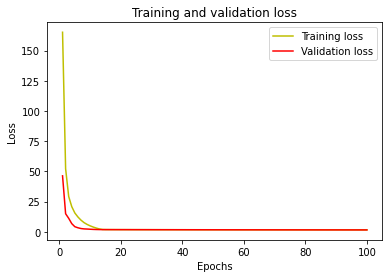

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 18ms/step


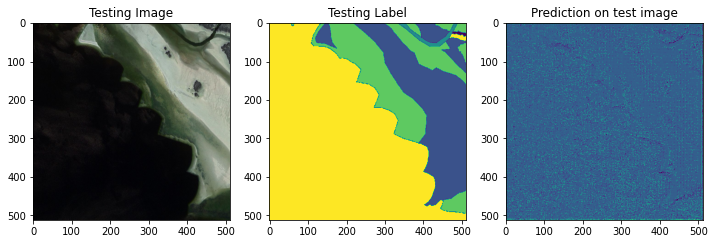

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
# individual classes -> iou = true_positives / (true_positives + false_positives + false_negatives)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
